# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 35kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

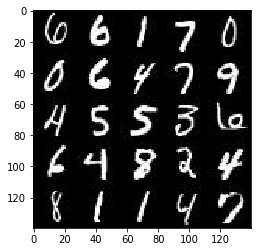

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

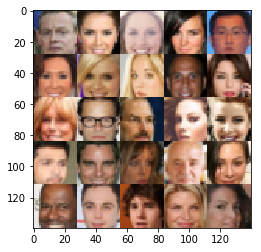

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1358... Generator Loss: 7.8203
Epoch 1/2... Discriminator Loss: 0.1355... Generator Loss: 15.6690
Epoch 1/2... Discriminator Loss: 0.3607... Generator Loss: 4.9545
Epoch 1/2... Discriminator Loss: 0.1259... Generator Loss: 3.0800
Epoch 1/2... Discriminator Loss: 0.4507... Generator Loss: 5.3737
Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 3.6009
Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 1.5246
Epoch 1/2... Discriminator Loss: 1.5912... Generator Loss: 8.2477
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 3.2021
Epoch 1/2... Discriminator Loss: 0.6635... Generator Loss: 1.2960


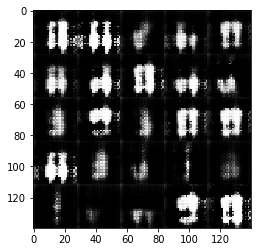

Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.7670
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 1.4984
Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 2.8480
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 4.8502
Epoch 1/2... Discriminator Loss: 0.3801... Generator Loss: 3.6962
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 1.6032
Epoch 1/2... Discriminator Loss: 0.6760... Generator Loss: 1.5325
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.4609
Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 0.9367


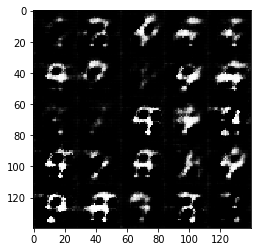

Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 2.1322
Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 1.9984
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 2.0365
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 1.9836
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.6762
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 3.9895
Epoch 1/2... Discriminator Loss: 0.3591... Generator Loss: 2.0905
Epoch 1/2... Discriminator Loss: 0.7662... Generator Loss: 1.2860


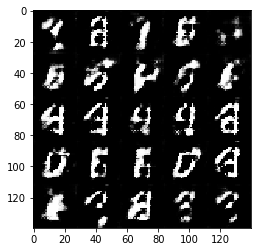

Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 2.5314
Epoch 1/2... Discriminator Loss: 0.4642... Generator Loss: 4.1152
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 3.8351
Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 3.5571
Epoch 1/2... Discriminator Loss: 2.2605... Generator Loss: 0.2374
Epoch 1/2... Discriminator Loss: 0.9049... Generator Loss: 1.0469
Epoch 1/2... Discriminator Loss: 0.5318... Generator Loss: 2.8570
Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 0.9863
Epoch 1/2... Discriminator Loss: 0.4333... Generator Loss: 1.9163
Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 0.9569


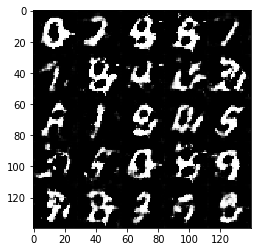

Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 2.8271
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 3.6201
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 4.1377
Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 1.9930
Epoch 1/2... Discriminator Loss: 1.7956... Generator Loss: 0.4027
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.4983
Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 0.6511... Generator Loss: 1.6495
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.9174


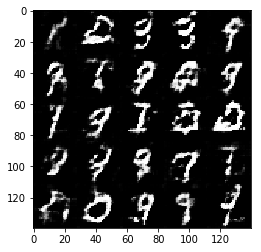

Epoch 1/2... Discriminator Loss: 0.7222... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.5555
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 0.6219... Generator Loss: 1.8286
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 0.7767... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 0.5932... Generator Loss: 1.3033
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 1.2093
Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 1.5098


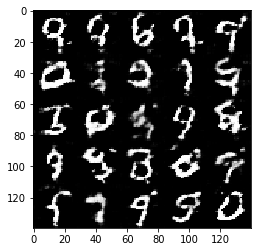

Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 0.9377
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.6076
Epoch 1/2... Discriminator Loss: 1.5610... Generator Loss: 0.3389
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 2.6668
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.8332
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 3.5553
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 0.8009


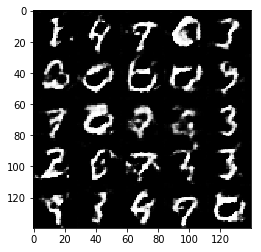

Epoch 1/2... Discriminator Loss: 0.6776... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 1.8505... Generator Loss: 3.3026
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.6061
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 3.0237
Epoch 1/2... Discriminator Loss: 1.7023... Generator Loss: 0.3605
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.3992
Epoch 1/2... Discriminator Loss: 0.7659... Generator Loss: 0.9951
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 1.5896
Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 1.0222


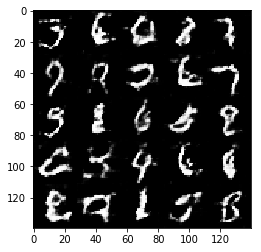

Epoch 1/2... Discriminator Loss: 0.8481... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 1.3178
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 1.4861
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 1.7415
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 2.1124
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.0975
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 1.3999


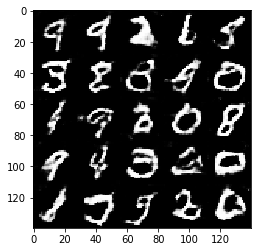

Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.5210
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 2.0790
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.2754
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.6266
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.4391
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 2.3423
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.7529


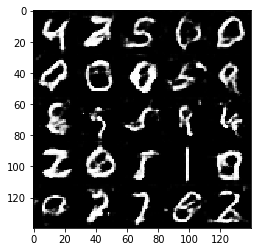

Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 2.5974
Epoch 2/2... Discriminator Loss: 1.9925... Generator Loss: 0.2273
Epoch 2/2... Discriminator Loss: 1.0271... Generator Loss: 1.9112
Epoch 2/2... Discriminator Loss: 0.8499... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 1.4478
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 2.5191
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.4353
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.5082
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 1.5981... Generator Loss: 0.3435


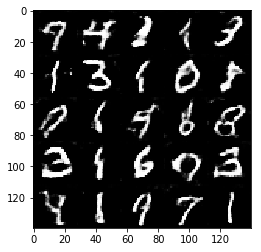

Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 1.6319
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 2.0316
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 0.4315
Epoch 2/2... Discriminator Loss: 1.7240... Generator Loss: 0.2790
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.5968
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 3.4423... Generator Loss: 4.3800
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 1.1784


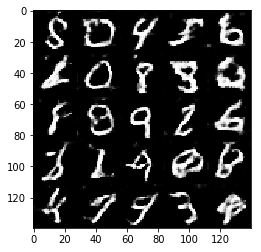

Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.5939
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.3802
Epoch 2/2... Discriminator Loss: 1.8221... Generator Loss: 0.2773
Epoch 2/2... Discriminator Loss: 1.5595... Generator Loss: 0.3252
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 1.7626
Epoch 2/2... Discriminator Loss: 0.9461... Generator Loss: 1.1361
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 1.5624
Epoch 2/2... Discriminator Loss: 1.0499... Generator Loss: 1.0959
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 0.8638


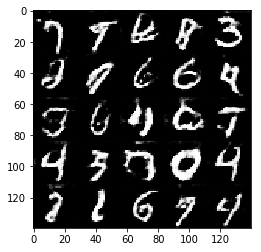

Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.5893
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.4328
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 1.4073
Epoch 2/2... Discriminator Loss: 0.7498... Generator Loss: 1.4204
Epoch 2/2... Discriminator Loss: 1.7582... Generator Loss: 0.3301
Epoch 2/2... Discriminator Loss: 1.7362... Generator Loss: 0.2684
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.0647
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 2.0282


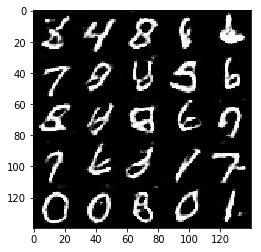

Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 1.1476
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 1.8055... Generator Loss: 0.3286
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.4704
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.4419
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 1.9037
Epoch 2/2... Discriminator Loss: 0.9255... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.0069
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 1.7504


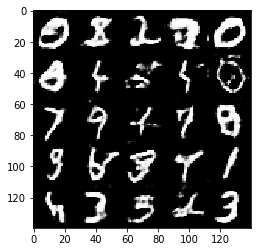

Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 2.0032
Epoch 2/2... Discriminator Loss: 1.2165... Generator Loss: 2.2216
Epoch 2/2... Discriminator Loss: 1.6659... Generator Loss: 0.3661
Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 0.9265
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.4242
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 1.1765
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 1.0419


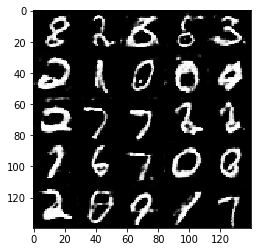

Epoch 2/2... Discriminator Loss: 0.7872... Generator Loss: 1.1874
Epoch 2/2... Discriminator Loss: 1.0182... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.5404
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.5512
Epoch 2/2... Discriminator Loss: 2.3159... Generator Loss: 0.1881
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.2267
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 0.9018
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.6878


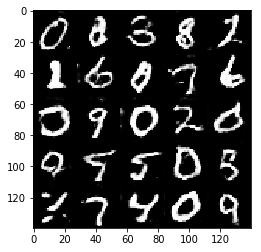

Epoch 2/2... Discriminator Loss: 5.2660... Generator Loss: 0.0150
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 0.2626... Generator Loss: 2.4650
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 2.0611
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 1.7044... Generator Loss: 0.3869
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 2.0201


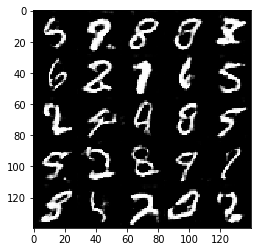

Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 0.5730... Generator Loss: 1.2793
Epoch 2/2... Discriminator Loss: 0.2881... Generator Loss: 1.8689
Epoch 2/2... Discriminator Loss: 0.6684... Generator Loss: 2.7969
Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 1.2633
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 0.7442


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6192... Generator Loss: 8.5507
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 2.8546
Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 2.4290
Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 4.3399
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 1.9887
Epoch 1/1... Discriminator Loss: 6.4822... Generator Loss: 0.0025
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 4.0885
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 4.3899


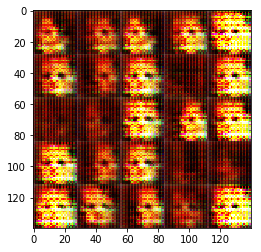

Epoch 1/1... Discriminator Loss: 0.1305... Generator Loss: 7.3493
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 2.7129... Generator Loss: 9.9851
Epoch 1/1... Discriminator Loss: 0.2258... Generator Loss: 2.2751
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.2609... Generator Loss: 2.2398
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 5.5384
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 8.4445
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.8777


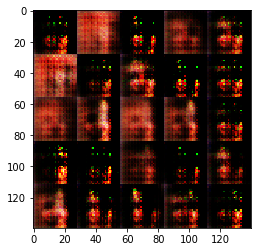

Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 3.2412
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 3.0854
Epoch 1/1... Discriminator Loss: 0.2784... Generator Loss: 2.2758
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 3.3491... Generator Loss: 5.0398
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 2.1332... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 0.1241... Generator Loss: 2.7774


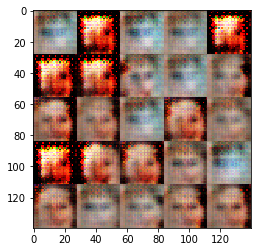

Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 3.0374
Epoch 1/1... Discriminator Loss: 2.6390... Generator Loss: 0.1426
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 0.2277... Generator Loss: 2.0424
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 2.8535
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 3.9198... Generator Loss: 6.3064


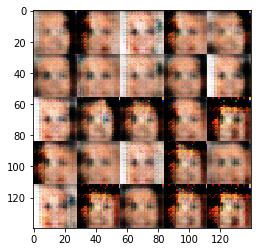

Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 2.6138
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 3.2808


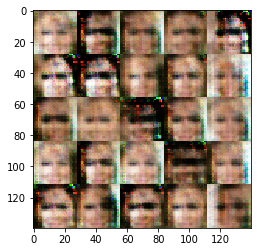

Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 3.7497... Generator Loss: 4.2362
Epoch 1/1... Discriminator Loss: 2.3155... Generator Loss: 0.1893
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 1.4568
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.6908... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 1.9596
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 1.4331


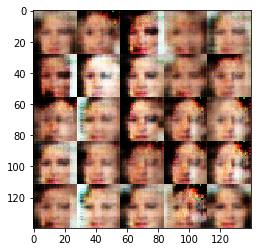

Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 2.2487
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.1584
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.3860
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 2.0129
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.8318


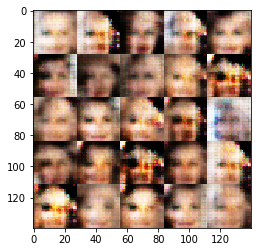

Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 1.5806
Epoch 1/1... Discriminator Loss: 3.6702... Generator Loss: 5.5614
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 2.4074... Generator Loss: 4.7909
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 2.1789
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 0.7770


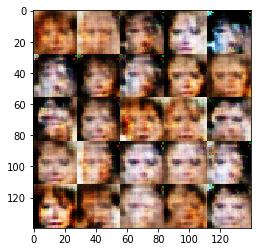

Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.6234
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.2997... Generator Loss: 2.1165
Epoch 1/1... Discriminator Loss: 1.6619... Generator Loss: 2.5933
Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 1.6444
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.2988
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.5798


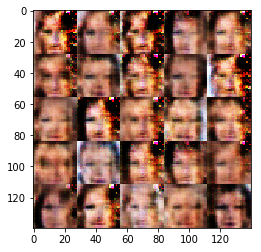

Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 2.4659
Epoch 1/1... Discriminator Loss: 1.8381... Generator Loss: 0.2089
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 2.4578
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 2.0537
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.4926


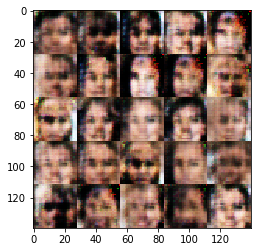

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.7162
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 1.5992
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.8762
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 2.1031
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 1.4915


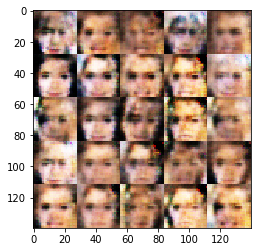

Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 1.7089
Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 2.2013
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 2.3883
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 0.1106... Generator Loss: 4.7955
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.6454
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.5010


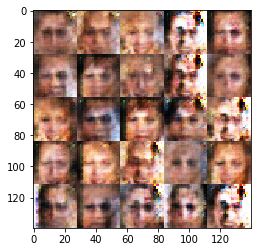

Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.9244
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 2.9727
Epoch 1/1... Discriminator Loss: 4.5361... Generator Loss: 0.0252
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.7753
Epoch 1/1... Discriminator Loss: 2.0590... Generator Loss: 3.7818
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.8591


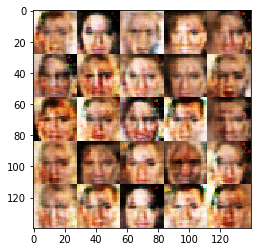

Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 2.1748
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.6520
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.8388
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 1.8060... Generator Loss: 3.3559
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 3.8054
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.2777


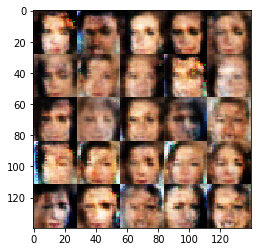

Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 2.1426... Generator Loss: 0.2034
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 0.3181
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 1.7538
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 2.1277
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.5872
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 2.3228


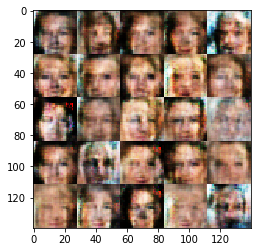

Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 0.2272... Generator Loss: 2.6567
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 2.2094
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.6403
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.8558


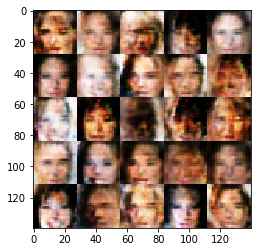

Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 2.6849
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 2.9155
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 2.2430... Generator Loss: 0.1538
Epoch 1/1... Discriminator Loss: 0.3062... Generator Loss: 3.2561
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.6026


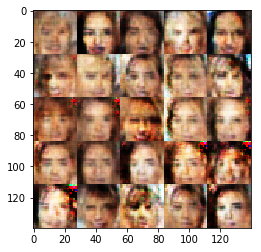

Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.4809
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 2.1119
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 0.9579


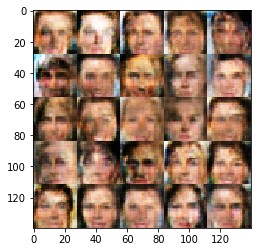

Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 3.7954
Epoch 1/1... Discriminator Loss: 0.3253... Generator Loss: 2.2017
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 3.0754
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 2.2647
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 0.2597... Generator Loss: 2.8096
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 0.2523... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 2.7614
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 0.8537


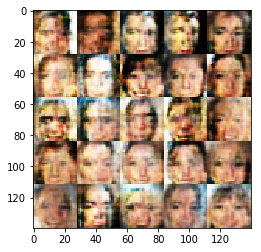

Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 1.6269
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 1.8972... Generator Loss: 3.4887
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 1.8885
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.7003


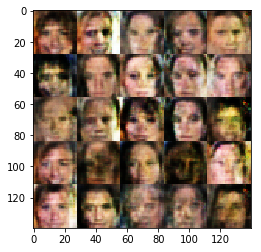

Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 2.3025
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.7566
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 3.1827
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 2.2727
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 2.0858... Generator Loss: 0.2563
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.3113


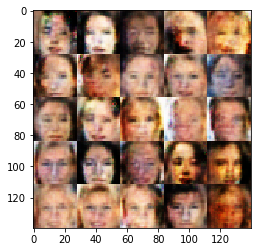

Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 2.2043
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 2.7645


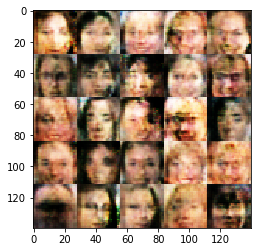

Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.7233... Generator Loss: 0.3472
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 1.4340
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 0.3066... Generator Loss: 2.6569
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 0.2523... Generator Loss: 2.1978
Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 1.6993


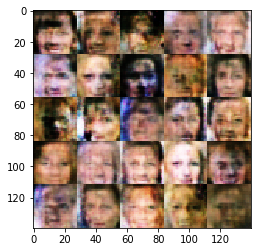

Epoch 1/1... Discriminator Loss: 0.2425... Generator Loss: 3.2177
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 4.0603... Generator Loss: 3.6371
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 0.9367


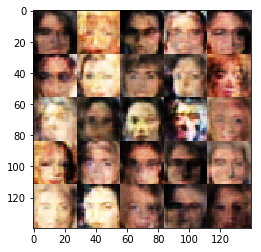

Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.6745
Epoch 1/1... Discriminator Loss: 0.2556... Generator Loss: 2.8566
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 0.1716... Generator Loss: 2.9644
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 3.5141... Generator Loss: 4.4447
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.5333


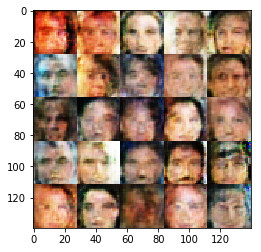

Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 2.7680
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.4190
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 3.3272
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 3.3162... Generator Loss: 3.6011
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8898


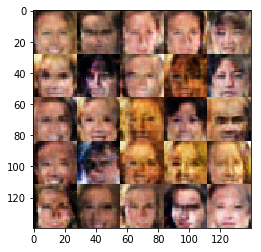

Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 1.5815
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 2.3169
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.5477
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 4.7902... Generator Loss: 3.5865
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 3.3563


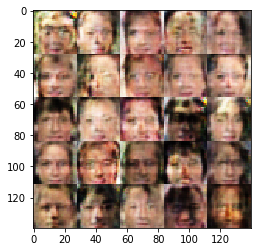

Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 2.2104
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.6665
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 1.7805
Epoch 1/1... Discriminator Loss: 3.0152... Generator Loss: 2.8388
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.0281


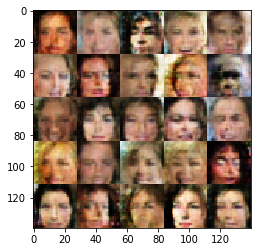

Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 2.3708
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 1.9327
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 1.2731


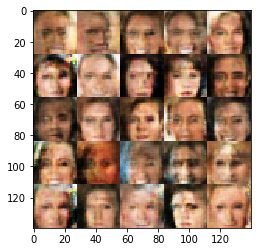

Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.3619
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 3.2587
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.6804


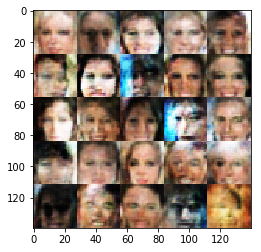

Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 2.0120
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.5230
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 3.0243
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.2860
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 1.2899
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 2.0465
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.4251


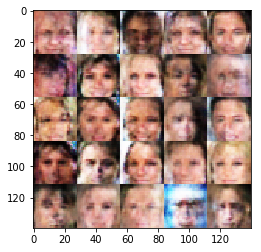

Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.7168
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 2.2930
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.1736


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.